<a href="https://colab.research.google.com/github/mancatha/P5/blob/main/P5model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers
!pip install transformers[torch] --upgrade
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.1 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [4]:
#downloding the train file from github using the url
!wget -O Train.csv "https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/blob/master/zindi_challenge/data/Train.csv"

--2023-11-03 08:52:24--  https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/blob/master/zindi_challenge/data/Train.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5330 (5.2K) [text/plain]
Saving to: ‘Train.csv’

Train.csv           100%[===================>]   5.21K  --.-KB/s    in 0s      

2023-11-03 08:52:24 (59.3 MB/s) - ‘Train.csv’ saved [5330/5330]



In [5]:
# Load the dataset and display some values
#df = pd.read_csv('../data/Train.csv')
df = pd.read_csv("https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/raw/master/zindi_challenge/data/Train.csv")



# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [6]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [7]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.000000


In [8]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [9]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [10]:
#after saving our dataset we load the dataset
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [11]:


tokenizer = AutoTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

In [12]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [14]:

# Load your model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("mdhugol/indonesia-bert-sentiment-classification",num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("mdhugol/indonesia-bert-sentiment-classification")

In [15]:
# Split the dataset into training and evaluation sets
train_dataset = dataset['train']
eval_dataset = dataset['eval']

In [21]:
training_args = TrainingArguments(
    output_dir="sentiment_analysis_trainer_model",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    load_best_model_at_end=True

)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted')
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted')
    return {"f1": f1, "precision": precision, "recall": recall}

In [23]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding ='max_length',return_tensors='pt')

In [25]:
# Initialize the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),  # DataCollatorWithPadding is correctly imported
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,

)

In [26]:
# Train the model
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.786700,0.747488,0.668521,0.638934,0.705000
2,0.792200,0.730909,0.681758,0.671550,0.716500
3,0.713200,0.706351,0.681688,0.649327,0.719500
4,0.680400,0.755578,0.693378,0.677920,0.729500
5,0.640900,0.717624,0.692059,0.661489,0.730000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

TrainOutput(global_step=5000, training_loss=0.7307941650390625, metrics={'train_runtime': 591.8946, 'train_samples_per_second': 67.571, 'train_steps_per_second': 8.447, 'total_flos': 916973899878204.0, 'train_loss': 0.7307941650390625, 'epoch': 5.0})

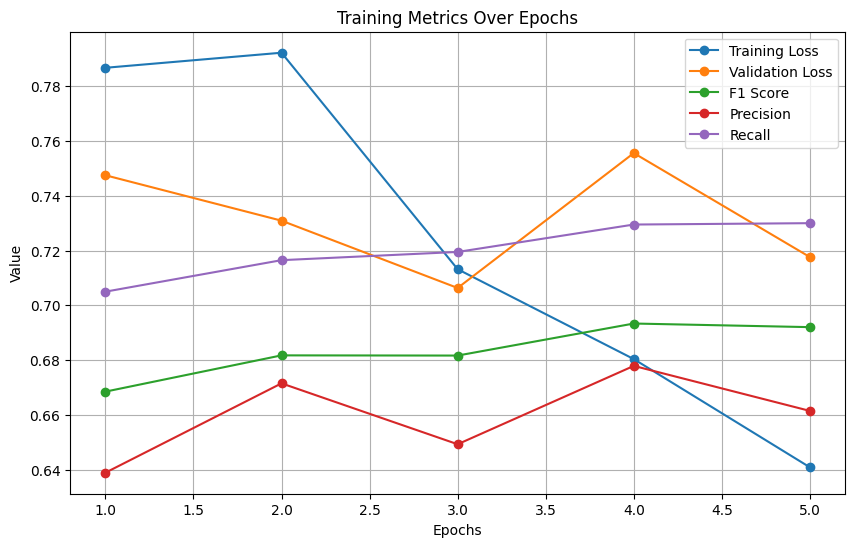

In [28]:
import matplotlib.pyplot as plt

# Your data
epochs = [1, 2, 3, 4, 5]
training_loss = [0.786700, 0.792200, 0.713200, 0.680400, 0.640900]
validation_loss = [0.747488, 0.730909, 0.706351, 0.755578, 0.717624]
f1 = [0.668521, 0.681758, 0.681688, 0.693378, 0.692059]
precision = [0.638934, 0.671550, 0.649327, 0.677920, 0.661489]
recall = [0.705000, 0.716500, 0.719500, 0.729500, 0.730000]

# Create subplots
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.plot(epochs, f1, label='F1 Score', marker='o')
plt.plot(epochs, precision, label='Precision', marker='o')
plt.plot(epochs, recall, label='Recall', marker='o')

# Customize the plot
plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [29]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),  # DataCollatorWithPadding is correctly imported
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [30]:
# Launch the final evaluation
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.7063506841659546,
 'eval_f1': 0.6816878983201176,
 'eval_precision': 0.6493267841117933,
 'eval_recall': 0.7195,
 'eval_runtime': 12.8591,
 'eval_samples_per_second': 155.532,
 'eval_steps_per_second': 19.441}